# Introductory Remarks

In the weeks before the COP27 climate conference in Sharm el Sheikh, Egypt a United Nations report indicates that scientists now believe global warming will likely bring an increase falling between two and three degrees. This projection is significantly higher than the target of 1.2% which experts urge us to not surpass. This new report suggests that in the last few years, thanks to COVID-19 and a number of factors such as the decreasing manufacturing price of alternative energy, we, as a species, should be able to avoid the worst scenario of human extinction. That said, we will not be able to avoid, as we already see, some fundamental changes and challenges to our way of living and social organization. Natural disasters are a clear, nearly everyday reminder of how human activities have irreversibly participated in global warming.

Our client contacted us as they wish to explore the possibility of using social media data as an additional way to develop an early response to natural disasters. In this report, I propose a preliminary analysis, using an open-source dataset of National Disasters Tweets and NLP machine-leaning binary classifiers to determine the feasibility of using social media information to help mitigate the risks of natural disasters. 


__Importation of all the python libraries necessary to start exploring the dataset__

In [2]:
# import libraries
from pprint import pprint
import logging
import pandas as pd

# setting logging for log file to record performance metrics from every model 
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s:%(name)s:%(message)s')
file_handler = logging.FileHandler('STATS_CAN DATA SCIENCE EXAM.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

__The inspection of the two other files in the Natural Disasters dataset, train.csv and sample-submission.csv, revealed that they are both unlabeled data. I therefore decided not to use them to carry machine-learning tasks__

In [6]:
# Load Natural Disasters training set
df_train = pd.read_csv('train_v2.csv')

## Exploratory Data Analysis

I first explore the training-set looking to start familiarizing myself with the data, but also identify:

1. Which metadata could be use to carry NLP text classification tasks.
2. Which cases, if any, needed to be excluded from the analysis because of missing data.
3. Possible duplicates.
4. Class balanced/imbalanced. 

In [24]:
# Get the number of cases and variables in the dataset
pprint('n : {} | # variables : {}'.format(df_train.shape[0], df_train.shape[1]))

'n : 7613 | # variables : 7'


### __Missing data__

In [25]:
# Overview of the variables in terms of missing data
df_train.isnull().sum()

id                  0
keyword            61
location         2533
text                0
target              0
geo_BERT_bool       0
geo_BERT_str        0
dtype: int64

### Duplicate data

In [45]:
# Overview of the variables in terms of duplicated data
df_train.duplicated().sum()

0

### About 'keyword' metadata

The tweets were manually classified or mapped to a category of disaster (e.g., apocalypse; army; famine, etc). The inspection of this variable revealed several important points. First, a number of categories tend to overlap. Second, a large number of those categories do not exactly fall within the larger umbrella of 'natural disasters'. Therefore, for my client, if time would have permitted, I would have excluded all the tweets that do not fall within the larger category of natural disasters. But because of time constraints, I could not carry this data preparation task. For instance, excluding a large number of tweets could potentially make it extremely hard to build good ML models. This data cleaning process would also potentially significantly affect the distribution of cases between disaster tweets and non-disaster tweets, which would then be required ... I therefore decided to not enroll this variable in my modeling effort and to keep all the tweets in the corpus. 

Example of categories that do not fall within the natural disasters umbrella:


                                'quarantine',
                                'collision',
                                'hijack',
                                'suicide%20bomb',
                                'hijacking',
                                'injury',
                                'bleeding',
                                'body%20bagging',
                                'arson',
                                'arsonist',
                                'terrorism',
                                'suicide%20bomber',
                                'weapons',
                                'terrorist',
                                'mass%20murderer',
                                'suicide%20bombing',
                                'riot'
                                
```python
# code to generate a set, or non-duplicative list of all the disaster categories in the dataset for manual inspection
from collections import Counter

disaster_cat = list(df_train.keyword)
set_disaster_cat = list(set(disaster_cat))
freq_disaster_cat = Counter(disaster_cat)

# if I were to proceed with exclusing non-natural disaster categories for the analysis, I would use the following code:
from disaster_cat_to_remove import disaster_cat_to_remove

disaster_cat_to_remove  = '|'.join(disaster_cat_to_remove)
df_train['disaster_cat_rm'] = np.where(df_train['keyword'].str.contains(disaster_cat_to_remove, na=0, case=False), 1, 0)
df_train = df_train[df_train['disaster_cat_rm']==0].reset_index(drop=True)

```

### About 'location' metadata

The location metadata contains geographical information found in the tweet string. Tweets that include such information (city, region, country) could be associated with a higher likelihood of being 'disaster-related' tweets. That said, the location variable in the original dataset has a high proportion of missing data (n=2533). A manual inspection of those cases reveals that a number of tweets with location metadata do contain some form of geographical information. 

### Using BERT NER to identify additional geographical information

Therefore I use a pre-trained BERT-NER algorithm to identify additional geographical information. I carried this task in a separate jupyter notebook since it is quite computationally expensive. This data enhancement task reduced the number of tweets with missing locations from 2533 to 2117 cases.

```python

from transformers import AutoTokenizer, TFAutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
model = TFAutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

def extracting_geo_loc():
    
    import pandas as pd
    df = pd.read_csv('train.csv')
    
    # load text data
    l_text = list(df['text'])
    
    # initialize two new variables
    l_loc = []
    l_loc_str = []
    
    for i,text in enumerate(l_text):
        pprint(i)
        l_chunk = []
        ner_results = nlp(text)
        if len(ner_results)!=0:
            # list of dicts
            for d in ner_results:
                if 'LOC' in d['entity']:
                    l_chunk.append(d['word'])
            if len(l_chunk)!=0:
                l_loc.append(True)
                l_loc_str.append(' '.join(l_chunk))
            else:
                l_loc.append(False)
                l_loc_str.append(False)
        else:
            l_loc.append(False)
            l_loc_str.append(False)
            

l_loc, l_loc_str = extracting_geo_loc()

df['geo_BERT_bool'] = l_loc
df['geo_BERT_str'] = l_loc_str

df.to_csv('train_v2.csv', index=False)
```

### About 'text' metadata

The analysis reveals no empty tweet, no duplicate, and no unlabeled case. The analysis also indicates that we are dealing with a balanced dataset. 

OrderedDict([(0, 4342), (1, 3271)])
[0.5703402075397347, 0.4296597924602653]


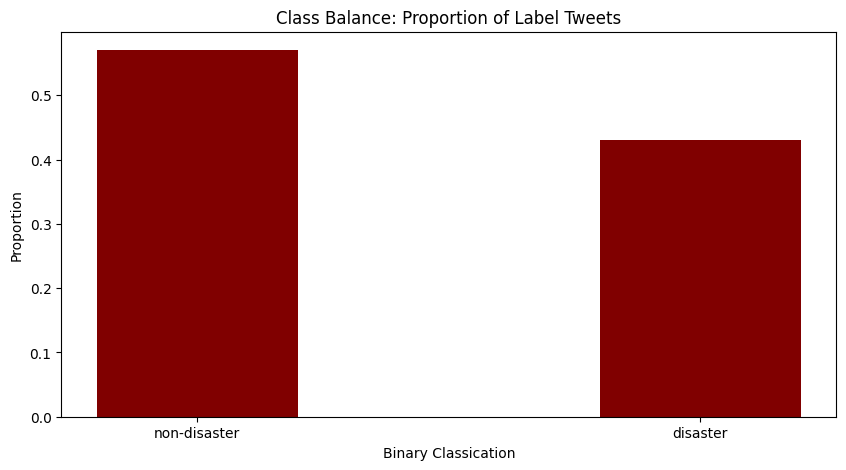

In [26]:
from collections import OrderedDict
import matplotlib.pyplot as plt

# wrangle data to plot bar chart
target_distro = df_train.target.value_counts()
target_distro = target_distro.to_dict(OrderedDict)

pprint(target_distro)

labels = ['non-disaster', 'disaster']
values = list(target_distro.values())
values = [x/df_train.shape[0] for x in values]
pprint(values)

fig = plt.figure(figsize = (10, 5))

# create the bar plot
plt.bar(labels, values, color = 'maroon', 
        width = 0.4)

plt.xlabel('Binary Classication')
plt.ylabel('Proportion')
plt.title('Class Balance: Proportion of Label Tweets')
plt.show()

## Text Pre-Processing

1. Removing punctuations.
2. Removing URL(s) from text.
3. Removing Twitter mentions (@....).
4. Removing Twitter hashtags (#....).
5. Convert to lower case.
6. Remove Tags.
7. Remove special characters and digits.
8. Stemming.
9. Lemmatisation.


In [103]:
# import the required libraries for text pre-processing
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Removing stopwords
stop_words = set(stopwords.words("english"))

#carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus
target_string = 'text'
corpus = []
for i in list(df_train.index.values): # list of index of the dataframe [0,1,2......]'
    
    text = df_train[f'{target_string}'][i]

    # Remove URL(s)
    text = re.sub(r"\S*https?:\S*", "", text)

    # Remove all @string from text
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))

    # Remove all #string from text
    text = " ".join(filter(lambda x:x[0]!='#', text.split()))
    
    # Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df_train[f'{target_string}'][i])

    # Convert to lowercase
    text = text.lower()

    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    # Convert to list from string
    text = text.split()

    # Stemming
    ps=PorterStemmer()

    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in
            stop_words]

    # transform list back into a string object
    text = " ".join(text)

    # add processed text to list for features engineering
    corpus.append(text)

# adding the processed text into dataframe
df_train['text_processed'] = corpus

df_train.head()

,id,keyword,location,text,target,geo_BERT_bool,geo_BERT_str,text_clean,len_text_raw,url_in_text,count_at_sym,dummy_at_sym,count_hash_sym,dummy_hash_sym,dummy_has_numbers,text_processed,len_text_processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,False,False,Our Deeds are the Reason of this #earthquake M...,69,0,0,0,1,1,0,deed reason earthquake may allah forgive u,42
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,True,La Ron ##ge Sa ##sk Canada,Forest fire near La Ronge Sask. Canada,38,0,0,0,0,0,0,forest fire near la ronge sask canada,37
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,False,False,All residents asked to 'shelter in place' are ...,133,0,0,0,0,0,0,resident asked shelter place notified officer ...,85
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,True,California,"13,000 people receive #wildfires evacuation or...",65,0,0,0,1,1,1,people receive wildfire evacuation order calif...,51
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,True,Ruby Alaska,Just got sent this photo from Ruby #Alaska as ...,88,0,0,0,2,1,0,got sent photo ruby alaska smoke wildfire pour...,54


## Data Enhancement > Feature Engineering

In addition to using three NLP approaches to feature engineering (bag-of-words; tf-idf; sentence-embedding), I also identified a number of variables of interest that can add predictive power to the ...

1. Lenght (in characters) of the tweet text; continuous variable.
2. lenght (in characters) of the processed Tweet text; continuous variable.
3. Doe the Tweet text contains URL(s); dummy.
4. Number of '@' in Tweet text; continuous variable, and recode as dummy.
5. Number of '#' in Tweet text; continuous variable, and recode as dummy.
6. Doe the Tweet txt contains numbers; dummy.
7. Doe the Tweet text contains geographical location; dummy.


In [37]:
import numpy as np
import re

# Creating a continuous variable that capture the original tweet's lenght
df_train['len_text_raw'] = df_train['text'].apply(lambda x: len(x))

# Creating a continuous variable that capture the processed tweet's lenght (number of symbols)
df_train['len_text_processed'] = df_train['text_processed'].apply(lambda x: len(x))

# Creating a dummy variable that indicates if the tweet contains at least one url : url_in_text {1}; no {0}
df_train['url_in_text'] = np.where(df_train['text'].str.contains('http', na=0, case=False), 1, 0)

# Creating a continuous variable that counts the number of '@' in tweet
counting_at = lambda x: x.count('@')
df_train['count_at_sym'] = [counting_at(t) for t in df_train['text_clean']]
df_train['dummy_at_sym'] = df_train['count_at_sym'].apply(lambda x: 1 if x != 0 else 0)

# Creating a continuous variable that counts the number of '#' in tweet
counting_hash = lambda x: x.count('#')
df_train['count_hash_sym'] = [counting_hash(t) for t in df_train['text_clean']]
df_train['dummy_hash_sym'] = df_train['count_hash_sym'].apply(lambda x: 1 if x != 0 else 0)

# Creating a dummy variable that capture if the tweet contains numerical values
def num_there(s):
    return any(i.isdigit() for i in s)

df_train['dummy_has_numbers'] = df_train['text_clean'].apply(num_there)
df_train['dummy_has_numbers'] = list(map(int, df_train['dummy_has_numbers']))


### Correlation Heatmap for New Variables

I checked for multi-collinearity for the new variables I just created. The correlation heatmap indicates that 'dummy_at_sym' and 'count_at_sym' and 'dummy_hash_sym' and 'count_hash_sym' are highly correlated. This is no surprise since the dummy variable is a recode of the continuous variable. In all the models presented in this report, I exclude both 'dummy_at_sym' and 'dummy_hash_sym'. If I could have afforded more time on this initial report for the client, I would have also controlled and investigate instances of colinearity for the NLP BoW and TF-IDF models.

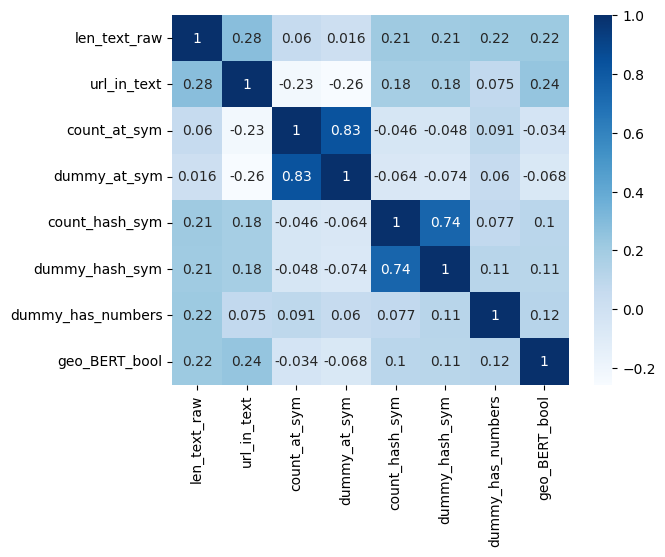

In [104]:
# list of new features
l_new_vars = ['len_text_raw',
              'url_in_text',
              'count_at_sym',
              'dummy_at_sym',
              'count_hash_sym',
              'dummy_hash_sym',
              'dummy_has_numbers',
              'geo_BERT_bool'
             ]

# create a dataframe including only those new variables
df_new_vars = df_train[l_new_vars]

# generate correlation score for each pair
check_corr = df_new_vars.corr()

# plot a heatmap
import seaborn as sns
sns.heatmap(check_corr, cmap="Blues", annot=True)
plt.show()


## Task 1 - BoW Model

maybe a few words here...

In [ ]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

logger.info('************ BoW: UniGrams')

# fit the bag-of-words model
vectorizer = CountVectorizer()
bag = vectorizer.fit_transform(corpus)

# get a list of all the keyword features
l_feature_bag = vectorizer.get_feature_names_out()
pprint("# unique tokens: {}".format(len(l_feature_bag)))

# add BoW features to df_train for training a model that included all features
df_bag = pd.DataFrame(bag.toarray(), columns=vectorizer.get_feature_names_out())
df_bag = df_bag.add_prefix('BOW_')

df_bag = df_bag.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

df_train_bag = pd.concat([df_train, df_bag], axis=1)



In [105]:
# import models & performance metrics libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# CONSTANT
RANDOM_STATE = 450

def split_x_y(df):
    """
    input: dataframe with features and target
    output: split dataframe into a features array and a target array
    """

    l_features = list(df.columns)
    l_features.remove('target')
    l_features.remove('text')
    l_features.remove('text_clean')
    l_features.remove('text_processed')
    l_features.remove('id')
    l_features.remove('keyword')
    l_features.remove('location')
    # l_features.remove('count_at_sym')
    # l_features.remove('count_hash_sym')
    l_features.remove('geo_BERT_str')

    X = np.array(df[l_features])

    y = df['target']
    y = np.array(y)

    return X, y, l_features

def run_model(X, y, model_str, class_model, class_name:str, model_spec:str, model_nlp:str, l_features:list):
    """
    abstracted method
    """
    
    # create training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # fit the model
    class_model.fit(X_train, y_train)
    
    # create the predictions
    y_predict = class_model.predict(X_test)

    # inspect Performance Indicators
    logger.info(class_name)
    logger.info("**** Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    logger.info("**** Recall %.3f" %metrics.recall_score(y_test, y_predict))
    logger.info("**** Precision %.3f" %metrics.precision_score(y_test, y_predict))
    logger.info("**** f1_score %.3f" %metrics.f1_score(y_test, y_predict))
    
    # get summary classication report
    print(classification_report(y_test, y_predict))
    
    train_accuracy = class_model.score(X_train, y_train)
    pprint('train_accuracy')
    pprint(train_accuracy)

    # get confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predict)
    pprint(cnf_matrix)
    logger.info('###### cnf_matrix :{}'.format(cnf_matrix))

    # plot heat map
    plot_cnf_matrix(cnf_matrix, class_name, model_spec, model_nlp)
    
    # inspect the feature_importances
    fitted_model = class_model.fit(X_train, y_train)
    if model_str == 'rf':
        potent_features = sorted(zip(fitted_model.feature_importances_, l_features), reverse=True)[:15]
    elif model_str == 'lg':
        importance = fitted_model.coef_[0]
        potent_features = pd.Series(importance, l_features)
        pprint(potent_features)
    else:
        potent_features = False
    
    return potent_features


def plot_cnf_matrix(cnf_matrix:list, class_name:str, model_spec:str, model_nlp:str):
    """
    input: confusion matrix
    output: data viz as heat map of counts of true positive, true negative, false positive, and false negative
    """

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'{model_nlp} Confusion matrix - Predicting Natural Disaster Tweets [{class_name} : {model_spec}]', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


### BoW Baseline Models (no additional features)

'logistic regression'
LogisticRegression(max_iter=10000, random_state=450)
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1078
           1       0.80      0.70      0.75       826

    accuracy                           0.79      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.79      0.79      0.79      1904

'train_accuracy'
0.9693466456472237
array([[934, 144],
       [248, 578]], dtype=int64)


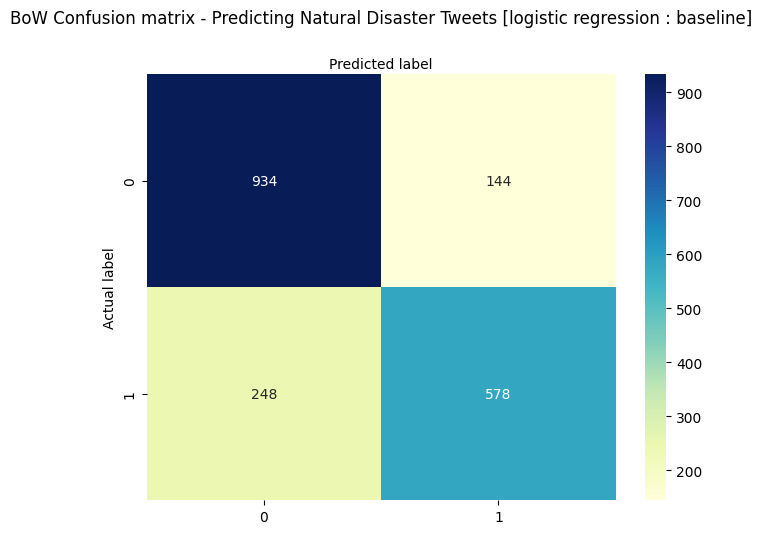

BOW_aa             0.122067
BOW_aaaa          -0.038182
BOW_aaaaaaallll    0.367444
BOW_aaaaaand       0.120508
BOW_aaarrrgghhh    0.244977
                     ...   
BOW_zzsee          0.000000
BOW_zztbvjypn     -0.084186
BOW_zzuz          -0.015683
BOW_zzweeezjug     0.082061
BOW_zzzz          -0.039371
Length: 20679, dtype: float64
'######################################################'
'Features with the highest coefficients'
BOW_aa             0.122067
BOW_aaaa          -0.038182
BOW_aaaaaaallll    0.367444
BOW_aaaaaand       0.120508
BOW_aaarrrgghhh    0.244977
                     ...   
BOW_zzsee          0.000000
BOW_zztbvjypn     -0.084186
BOW_zzuz          -0.015683
BOW_zzweeezjug     0.082061
BOW_zzzz          -0.039371
Length: 20679, dtype: float64
'######################################################'


In [106]:
# Creating training data set from BoW and target variable
X = bag.toarray()
y = np.array(df_train['target'])

# Building a dictionary of classifier models
d_task_1_classifier = {
                       # 'rf': [RandomForestClassifier(random_state=1, n_jobs=-1), 'random forest', 'baseline', 'BoW'],
                        'lg': [LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic regression', 'baseline', 'BoW'],
                       # 'svc': [SVC(random_state=RANDOM_STATE), 'support vector machine'],
                       # 'sgd': [SGDClassifier(max_iter=10000), 'stochastic gradient descent'],
                      }

# run classifier
logger.info('-----> task 1 - baseline')
for model in d_task_1_classifier.keys():
    class_spec, class_name, model_spec, model_nlp = d_task_1_classifier[model]
    pprint(class_name)
    pprint(class_spec)
    potent_features = run_model(X, y, model, class_spec, class_name, model_spec, model_nlp, list(df_bag.columns))
    pprint('######################################################')
    pprint('Features with the highest coefficients')
    pprint(potent_features)
    pprint('######################################################')
    

### BoW Models with additional features

'logistic regression'
LogisticRegression(max_iter=10000, random_state=450)
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1088
           1       0.81      0.71      0.76       816

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904

'train_accuracy'
0.9703976177964617
array([[953, 135],
       [238, 578]], dtype=int64)


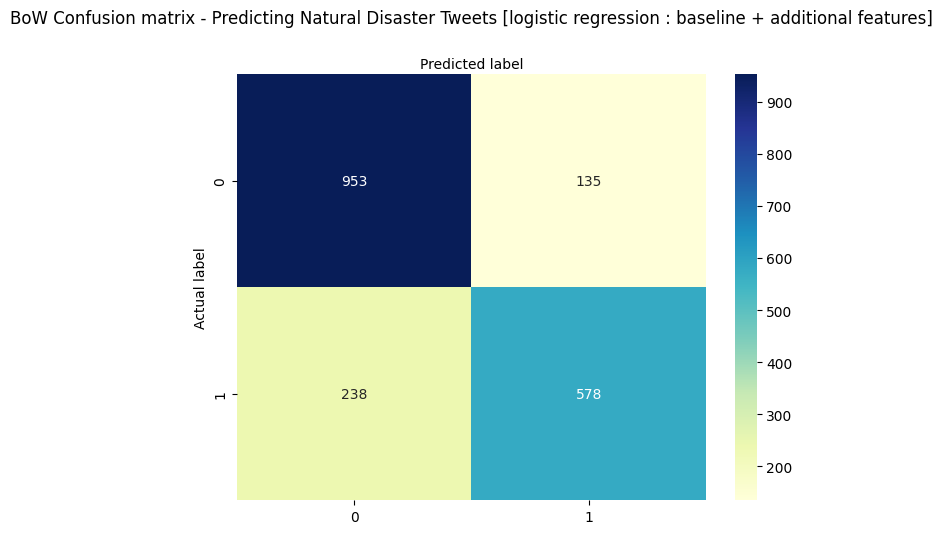

geo_BERT_bool     1.081885
len_text_raw     -0.008473
url_in_text       0.826752
count_at_sym     -0.119153
dummy_at_sym      0.005371
                    ...   
BOW_zzsee        -0.142378
BOW_zztbvjypn     0.000000
BOW_zzuz          0.000000
BOW_zzweeezjug    0.043320
BOW_zzzz         -0.039102
Length: 20688, dtype: float64
'######################################################'
'Features with the highest coefficients'
geo_BERT_bool     1.081885
len_text_raw     -0.008473
url_in_text       0.826752
count_at_sym     -0.119153
dummy_at_sym      0.005371
                    ...   
BOW_zzsee        -0.142378
BOW_zztbvjypn     0.000000
BOW_zzuz          0.000000
BOW_zzweeezjug    0.043320
BOW_zzzz         -0.039102
Length: 20688, dtype: float64
'######################################################'


In [107]:
# Split dataset into features and target arrays
X, y, l_features = split_x_y(df_train_bag)

# Building a dictionary of classifier models
d_task_1_classifier = {
                       # 'rf': [RandomForestClassifier(random_state=1, n_jobs=-1), 'random forest', 'baseline + additional features', 'BoW'],
                       'lg': [LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic regression', 'baseline + additional features', 'BoW'],
                       # 'svc': [SVC(random_state=RANDOM_STATE), 'support vector machine'],
                       # 'sgd': [SGDClassifier(max_iter=10000), 'stochastic gradient descent'],
                      }

# run classifier
logger.info('-----> task 1 - with additional features: @, #, lenght, url, etc.')
for model in d_task_1_classifier.keys():
    class_spec, class_name, model_spec, model_nlp = d_task_1_classifier[model]
    pprint(class_name)
    pprint(class_spec)
    potent_features = run_model(X, y, model, class_spec, class_name, model_spec, model_nlp, l_features)
    pprint('######################################################')
    pprint('Features with the highest coefficients')
    pprint(potent_features)
    pprint('######################################################')

## Task 2 - TF-IDF Model

Using the Python SKlearn library, I relied on a classic information retrieval (IF) statistical measure called Term Frequency-Inverse Document Frequency (TF-IDF) to convert text data into vectors (features of keywords) that can be used as predictors in the binary classifiers I am deploying. TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents (Dey, Jenamani, & Thakkar, 2017). I used the pre-processed text or string data of the 7613 Tweets included in the Natural Disasters training set as input data.

TF-IDF is more powerful and sophisticated than a simple Count Vectorizer (CV). Since CV only counts the frequency or mark the presence/absence of words in each document, it can result in a bias in favor of the most frequent words and thus ignore rare words. TF-IDF overcomes this limitation as it considers the overall document weight of a word.

Once the program has produced a preprocessed list of all the vocabulary of size N or corpus, the TF-IDF algorithm creates a matrix of up to v features. Based on previous experience, I set the maximum number of features v to 10,000. In other words, for the preprocessed text of preprint document j — i.e., siren everywhere — the features __siren__ and __everywhere__ would have a TF-IDF score of (1/# of word occurrence in the corpus). In this example, all the other features representing words, v-3, would be assigned a score of 0 since they were not found in document j. 

This procedure yields an array containing 7613 rows (Tweets) and 10,000 columns (10,000 continuous variables ranging from a TF-IDF score of 0 to 1; one variable representing a different keyword).  


In [108]:
# import tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 10000
logger.info('^^^^^^ tf-idf-max_features :{}'.format(max_features))
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
X_tf_idf = tf_idf_vectorizer.fit_transform(corpus)
X_tf_idf.shape

# Add tf-idf features to df_train
df_tf = pd.DataFrame(X_tf_idf.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
df_tf = df_tf.add_prefix('tfidf_')

df_tf = df_tf.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

df_train_tf = pd.concat([df_train, df_tf], axis=1)

### TF-IDF Baseline Models (no additional features)

LogisticRegression(max_iter=10000, random_state=450)
'logistic regression'
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1085
           1       0.83      0.66      0.74       819

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.79      1904
weighted avg       0.80      0.80      0.79      1904

'train_accuracy'
0.8877211420564022
array([[978, 107],
       [280, 539]], dtype=int64)


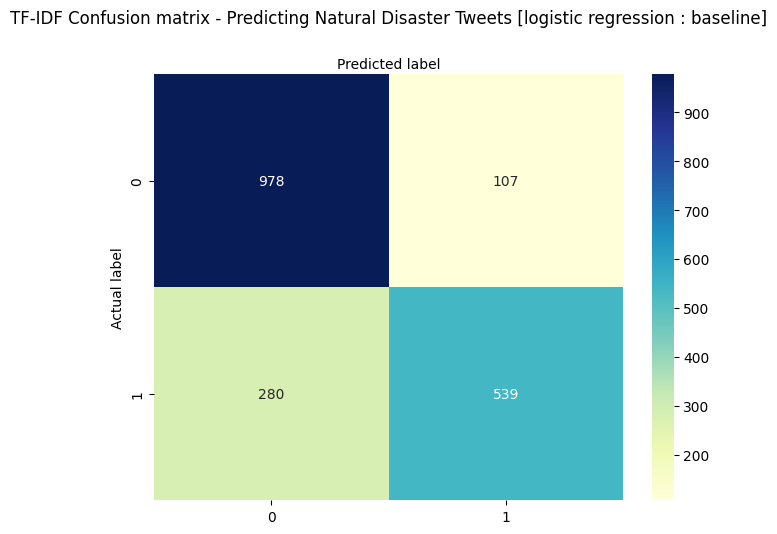

tfidf_aa            0.184651
tfidf_ab            0.181960
tfidf_aba           0.260427
tfidf_abandon      -0.242694
tfidf_abandoned     0.344366
                      ...   
tfidf_zzpojgngaj    0.152232
tfidf_zzr           0.075387
tfidf_zzsee        -0.164953
tfidf_zztbvjypn    -0.088288
tfidf_zzuz         -0.064724
Length: 10000, dtype: float64
'######################################################'
'Features with the highest coefficients'
tfidf_aa            0.184651
tfidf_ab            0.181960
tfidf_aba           0.260427
tfidf_abandon      -0.242694
tfidf_abandoned     0.344366
                      ...   
tfidf_zzpojgngaj    0.152232
tfidf_zzr           0.075387
tfidf_zzsee        -0.164953
tfidf_zztbvjypn    -0.088288
tfidf_zzuz         -0.064724
Length: 10000, dtype: float64
'######################################################'


In [111]:
# transform pd dataframe into an array
X = X_tf_idf.toarray()

# Building a dictionary of classifier models
d_task_2_classifier = {
                       # 'rf': [RandomForestClassifier(random_state=1, n_jobs=-1), 'random forest', 'baseline', 'TF-IDF'],
                        'lg': [LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic regression', 'baseline', 'TF-IDF'],
                       # 'svc': [SVC(random_state=RANDOM_STATE), 'support vector machine'],
                       # 'sgd': [SGDClassifier(max_iter=10000), 'stochastic gradient descent'],
                      }

# run classifier
logger.info('-----> task 2 - baseline')
for model in d_task_2_classifier.keys():
    class_spec, class_name, model_spec, model_nlp = d_task_2_classifier[model]
    pprint(class_spec)
    pprint(class_name)
    potent_features = run_model(X, y, model, class_spec, class_name, model_spec, model_nlp, list(df_tf.columns))
    pprint('######################################################')
    pprint('Features with the highest coefficients')
    pprint(potent_features)
    pprint('######################################################')
    

### TF-IDF Baseline Models (with additional features)

LogisticRegression(max_iter=10000, random_state=450)
'logistic regression'
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1087
           1       0.82      0.69      0.75       817

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

'train_accuracy'
0.859344894026975
array([[967, 120],
       [257, 560]], dtype=int64)


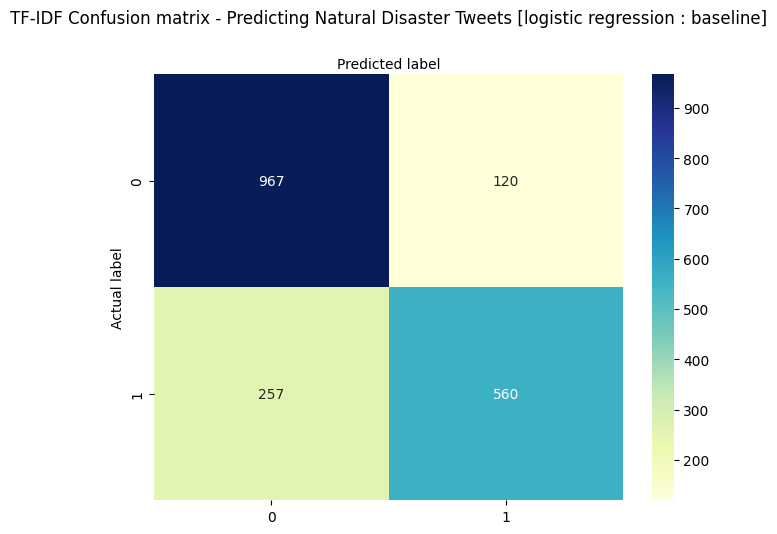

geo_BERT_bool       1.123021
len_text_raw       -0.006556
url_in_text         0.419218
count_at_sym       -0.144139
dummy_at_sym       -0.033819
                      ...   
tfidf_zzpojgngaj    0.000000
tfidf_zzr           0.066279
tfidf_zzsee        -0.107806
tfidf_zztbvjypn    -0.107117
tfidf_zzuz         -0.051036
Length: 10009, dtype: float64
'######################################################'
'Features with the highest coefficients'
geo_BERT_bool       1.123021
len_text_raw       -0.006556
url_in_text         0.419218
count_at_sym       -0.144139
dummy_at_sym       -0.033819
                      ...   
tfidf_zzpojgngaj    0.000000
tfidf_zzr           0.066279
tfidf_zzsee        -0.107806
tfidf_zztbvjypn    -0.107117
tfidf_zzuz         -0.051036
Length: 10009, dtype: float64
'######################################################'


In [114]:
# Split dataset into features and target arrays
X, y, l_features = split_x_y(df_train_tf)

# Building a dictionary of classifier models
d_task_2_classifier = {
                       #'rf': [RandomForestClassifier(random_state=1, n_jobs=-1), 'random forest', 'baseline + additional features', 'TF-IDF'],
                        'lg': [LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic regression', 'baseline', 'TF-IDF'],
                       # 'svc': [SVC(random_state=RANDOM_STATE), 'support vector machine'],
                       # 'sgd': [SGDClassifier(max_iter=10000), 'stochastic gradient descent'],
                      }

# run classifier
logger.info('-----> task 2 - baseline + additional features')
for model in d_task_2_classifier.keys():
    class_spec, class_name, model_spec, model_nlp = d_task_2_classifier[model]
    pprint(class_spec)
    pprint(class_name)
    potent_features = run_model(X, y, model, class_spec, class_name, model_spec, model_nlp, l_features)
    pprint('######################################################')
    pprint('Features with the highest coefficients')
    pprint(potent_features)
    pprint('######################################################')

## TASK 3 - Pre-trained Word Embeddings + Linear Classifier Model

For the third task, I will be applying the word embedding technique to handle our binary textual classification problem. For the transformation of Tweet data, word embedding would most likely fall short. A better approach is to mobilize Sentence Embedding (SE), or 'to map each input instance to a single embedding that represents the entire sequence of words'. The main idea of SE or Tweet Embedding techniques in our case is to represent entire tweets and their semantic information as vectors. Such an approach help bring context and intention to machine-learning.


### Step 1 - Tokenization 

In [115]:
# transform list of Tweet strings into a list of list of tokens
l_corpus = [x.split() for x in corpus]
pprint('lenght corpus of Tweets:{}'.format(len(l_corpus)))


'lenght corpus of Tweets:7613'


### Step 2 - Tagging

In [116]:
# import model Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(l_corpus)]
pprint('tagged_data - a peek')
pprint(tagged_data[:10])

'tagged_data - a peek'
[TaggedDocument(words=['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'], tags=[0]),
 TaggedDocument(words=['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], tags=[1]),
 TaggedDocument(words=['resident', 'asked', 'shelter', 'place', 'notified', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expected'], tags=[2]),
 TaggedDocument(words=['people', 'receive', 'wildfire', 'evacuation', 'order', 'california'], tags=[3]),
 TaggedDocument(words=['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pours', 'school'], tags=[4]),
 TaggedDocument(words=['rockyfire', 'update', 'california', 'hwy', 'closed', 'direction', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfire'], tags=[5]),
 TaggedDocument(words=['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flooding', 'street', 'manitou', 'colorado', 'spring', 'area'], tags=[6]),
 TaggedDocument(words=['top', 'hill', 'see', 'fire', 'wood'], tags=[7]),
 TaggedDocument(words=['

### Step 3 - Train Model

In [117]:
# initialization of doc2vec model
model = Doc2Vec(tagged_data, vector_size = 500, window = 2, min_count = 1, epochs = 100)

# build vocabulary
model.build_vocab(tagged_data)

# train model
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# get vector for first tweet of dataset
print(model.infer_vector(l_corpus[0]))


[ 0.02057526 -0.03413228 -0.0032844  ... -0.02935172 -0.0424735
 -0.00565934]


### Step 4 - Generate Word Embedding Matrix

In [118]:
X_word_emb = [model.infer_vector(l_corpus[i]) for i,x in enumerate(l_corpus)]

### Step 5 - Run Linear Classifier

'stochastic gradient descent'
SGDClassifier(max_iter=5000)
              precision    recall  f1-score   support

           0       0.82      0.31      0.45      1106
           1       0.49      0.91      0.63       798

    accuracy                           0.56      1904
   macro avg       0.66      0.61      0.54      1904
weighted avg       0.68      0.56      0.53      1904

'train_accuracy'
0.5647223681905763
array([[347, 759],
       [ 75, 723]], dtype=int64)


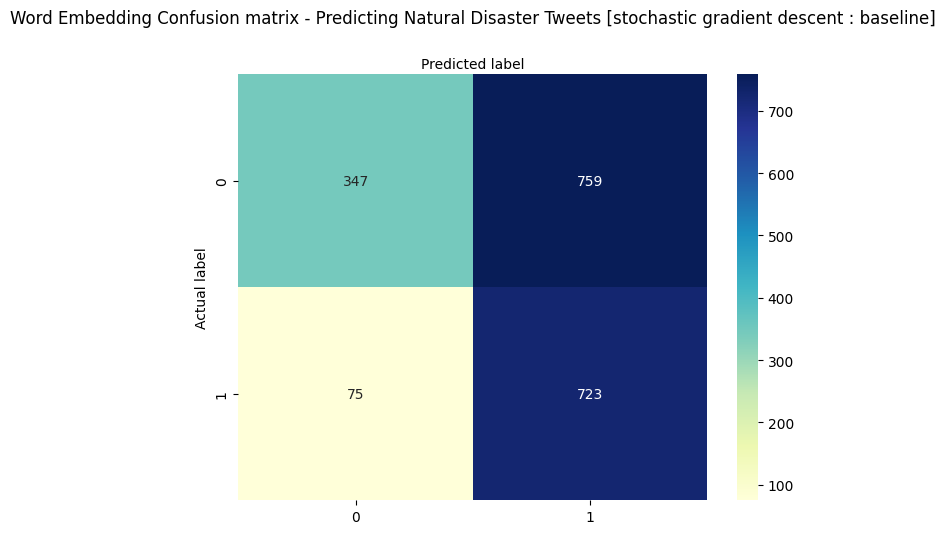

'######################################################'
'Features with the highest coefficients'
False
'######################################################'


In [119]:
# Building a dictionary of classifier models
d_task_3_classifier = {
                      'sgd': [SGDClassifier(max_iter=5000), 'stochastic gradient descent', 'baseline', 'Word Embedding'],
                      }

# run classifier
logger.info('-----> task 3 - Baseline')
for model in d_task_3_classifier.keys():
    class_spec, class_name, model_spec, model_nlp = d_task_3_classifier[model]
    pprint(class_name)
    pprint(class_spec)
    potent_features = run_model(X, y, model, class_spec, class_name, model_spec, model_nlp, l_features)
    pprint('######################################################')
    pprint('Features with the highest coefficients')
    pprint(potent_features)
    pprint('######################################################')

## Task 4 - Recommendations to the Clients

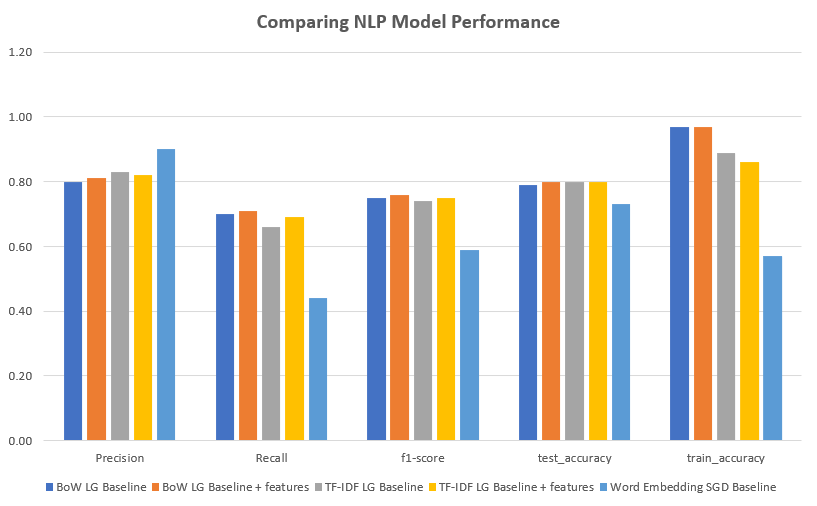

The clients ordered a feasibility report to explore the viability of developing, in production, a Natural Disaster Monitoring tool that would use Twitter feed as input data to predict, or identify early, risks of natural disasters or natural disasters unfolding in real-time. This tool could be especially useful in areas or regions where national infrastructure is lacking.

The performance indicators for the first two classifiers (BoW and TF-IDF) are remarkably similar with a precision score of around 80% and an f1-score of 75%. Although, at first sight, our final, more sophisticated, Word Embedding SGD classifier clocked a poor 57% accuracy in training, it is important to highlight that I only use a vector of length 500. Put differently, with such a relatively small vector, the classifier still recorded a high precision score of 90%. The trade-off between precision and recall in this case could be something of interest to our clients. In other words, if our client is mostly interested in building or deploying a natural disaster system or 'sniffer' that limits the number of false negatives (tweets pertaining to natural disasters that goes undetected), I would recommend the final model as a binary classifier that could be useful, if more attention and engineering development are applied to the preliminary model I provide here. 

On the other hand, if the client is looking for a classifier where both false negatives and false positives are kept at an acceptable level, or similar level, I would recommend the clients' engineers to keep experimenting with either BOW or TF-IDF. There are a number of excellent binary classifiers that I did not test here that could potentially generate a significant gain in performance: Naive Bayes, K-Nearest Neighbours.

### Beyong the Black-Box of NLP Machine-Learning

The clients were also interested in understanding how the models arrived at its classification. For that purpose, for most model, I provide in the report, the list of the 20 features with the largest coefficient. Arguably, more work need to be done to better identify which keywords are potent with predictive power. That said, the baseline + feature models indicates that the presense of a geographical location in a tweet is the strongest predictor of natural disaster. The lenght of Tweet is negatively associated with disaster tweet. It makes good sense since tweets about natural disaster are more efficient if they are short, to the point, and carrying a limited amont of critical information. 

Althought I only developed a few features outside the NLP models, I would stronly recommand the clients to continue developing features capturing elements such as the number of symbols, the number of pronoums, etc..


### Concerns over Natural Disasters Dataset Quality

If the client decided to pursue this engineering project, I would strongly recommend carefully auditing the Natural Disasters Dataset for quality-control. For one, a more accurate approach would be to exclude all the tweets from disaster categories that do not pertain to natural disasters. Again, here I am making this recommandetion based on my understanding of the clients'needs which indicate an interest in developing a binary classifier of natural disaster events on Twitter. If it is the case, then removing all non-natural disaster tweets might result in a small training set. I recommend that the clients think about building their own training-set.

There is another glaring reason for such recommendation. While manually inspecting the target metadata, I would several instances of misclassification. For instance, the worker in charge of manually labeling the tweets corpus must have not been a hockey fan. One tweet pertaining to the #AvalancheColorado Stanley Cup run last year was actually labeled as a Natural Disaster tweet....Avalanche. This should suffice to raise some concerns with the clients about the viability of this dataset as a stand-alone training set for engineering tasks.


# Concluding Remarks

The Twitter world would be happy that our clients are thinking of using Tweets to help mitigate the risks and hazards of climate change. Exploring 'crowd-sourced' or how non-expert communication ecosystems can participate in dealing with an increasing number of natural disasters each season is a worthwhile endeavor.